In [2]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def get_data(data_dir):
    images = []
    labels_array = []
    for label in labels:
        path = os.path.join(data_dir, label)  # e.g., train/PNEUMONIA
        class_num = labels.index(label)      # 0 for PNEUMONIA, 1 for NORMAL
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize to 128x128
                images.append(resized_arr)
                labels_array.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(images), np.array(labels_array)

In [4]:
X_train,y_train= get_data("chest_xray/chest_xray/train")
X_test,y_test = get_data("chest_xray/chest_xray/test")
X_val,y_val = get_data("chest_xray/chest_xray/val")

Error loading image .DS_Store: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error loading image .DS_Store: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error loading image .DS_Store: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error loading image .DS_Store: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [5]:
X_test.shape

(624, 128, 128)

In [6]:
pneumonia = os.listdir("chest_xray/chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/chest_xray/train/PNEUMONIA"

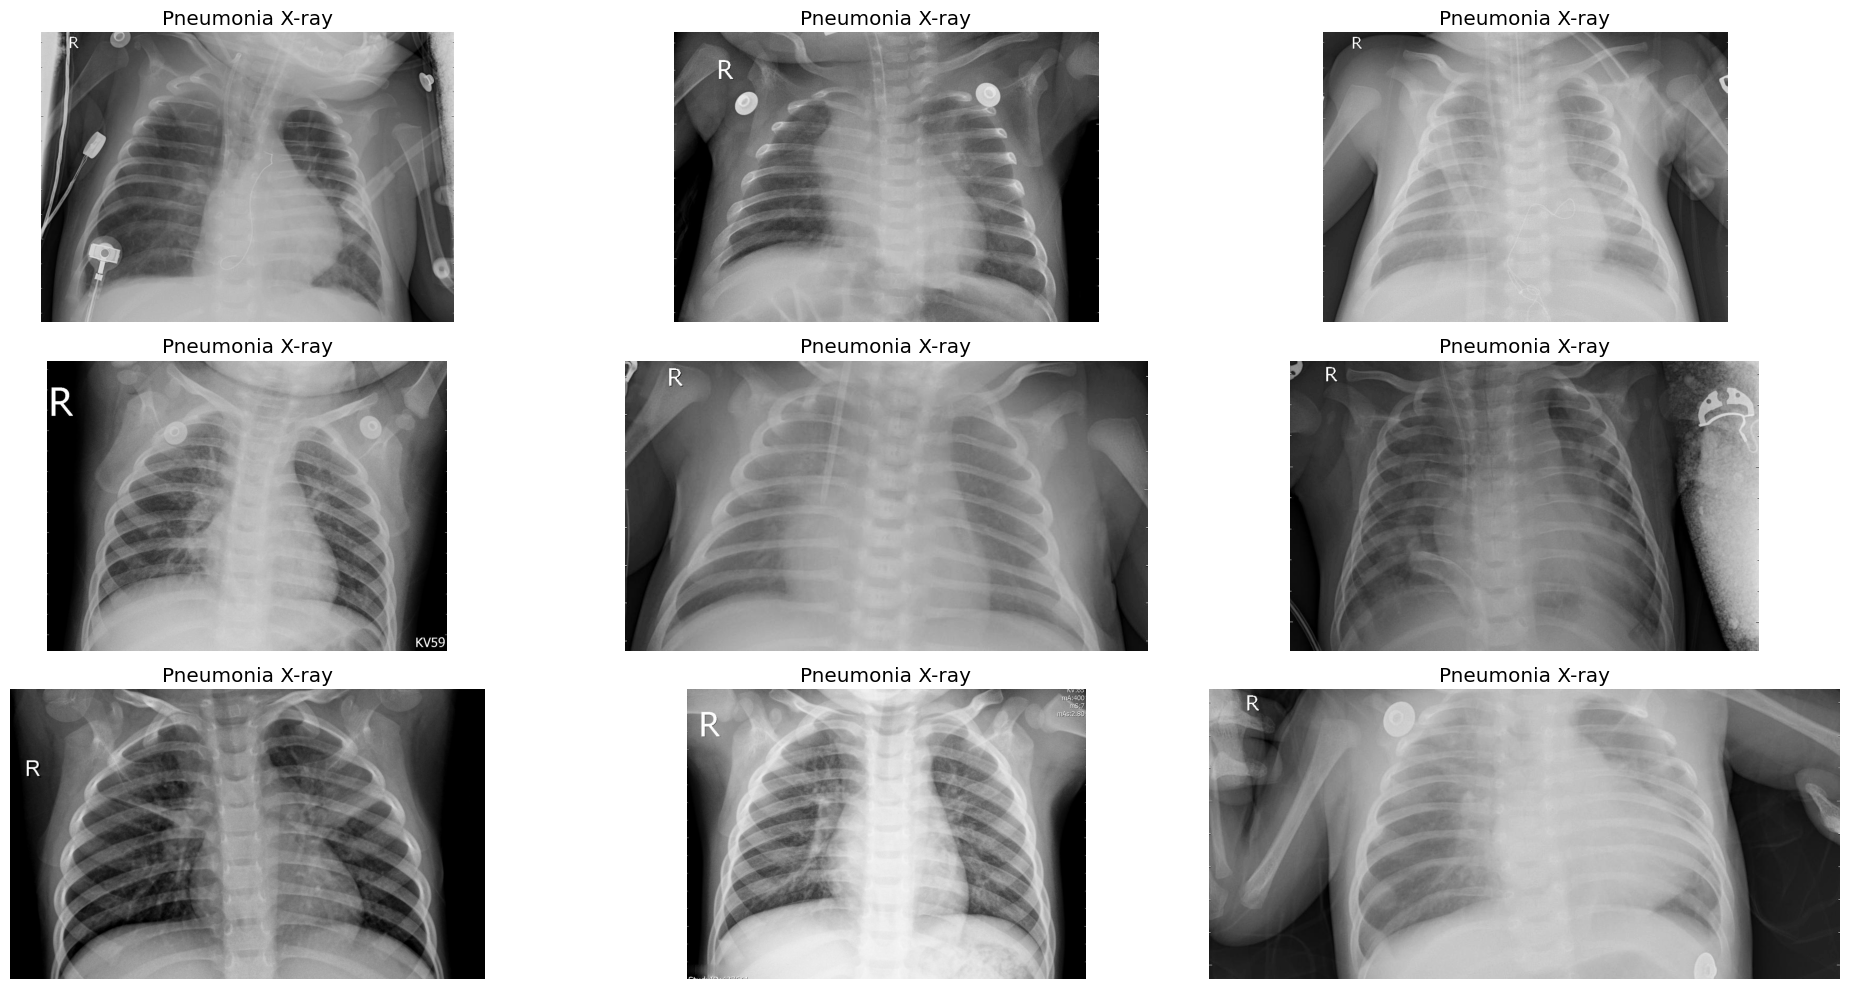

In [7]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(pneumonia_dir,pneumonia[i]))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title('Pneumonia X-ray')
plt.tight_layout()
plt.show()

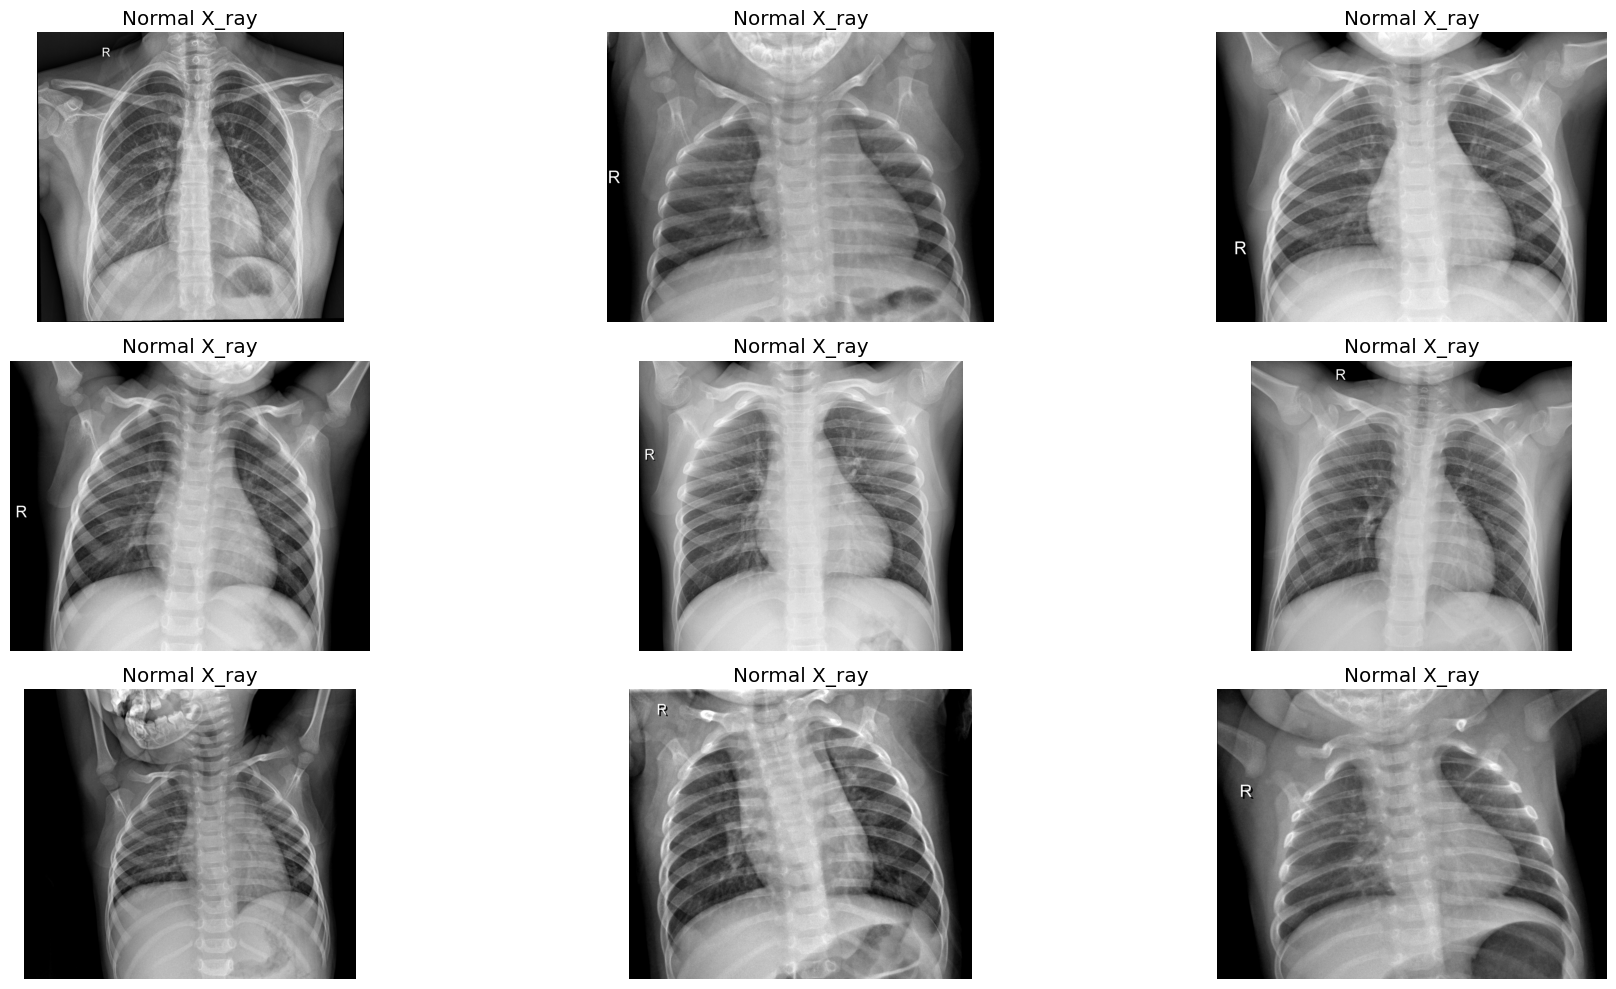

In [8]:
normal = os.listdir("chest_xray/chest_xray/train/NORMAL")
normal_dir = "chest_xray/chest_xray/train/NORMAL"
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(normal_dir,normal[i]))
    plt.imshow(img,cmap="gray")
    plt.axis("off")
    plt.title("Normal X_ray")
plt.tight_layout()
plt.show()

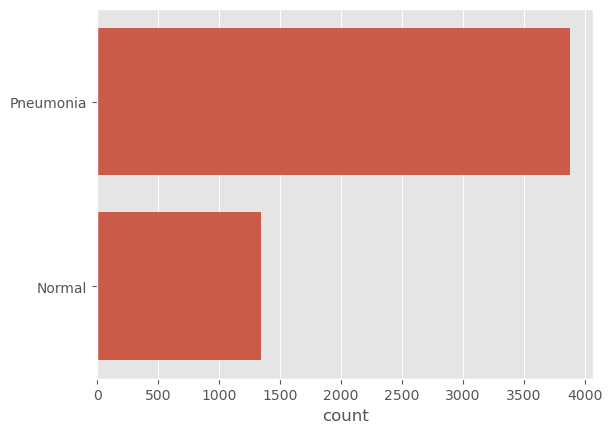

In [10]:
listCount = []
for i in range (y_train.shape[0]):
    if y_train[i]==0:
        listCount.append("Pneumonia")
    else:
        listCount.append("Normal")
sns.countplot(listCount)
plt.show()

In [11]:
# data augmentation 

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.2,
                  rotation_range=40,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    "chest_xray/chest_xray/train",
    batch_size=40,
    target_size=(128,128),
    class_mode = "categorical",
    shuffle=True,
    seed=42,
    color_mode= "rgb"
)
valid_generator = valid_datagen.flow_from_directory(
    "chest_xray/chest_xray/val",
    batch_size = 40,
    target_size=(128,128),
    class_mode = "categorical",
    shuffle=True,
    color_mode = "rgb"
)
test_generator = test_datagen.flow_from_directory(
    "chest_xray/chest_xray/test",
    batch_size=40,
    target_size=(128,128),
    class_mode = "categorical",
    shuffle = True,
    seed=42,
    color_mode = "rgb"
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
valid_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [17]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [18]:
class_labels = train_generator.class_indices

In [19]:
class_name = {value:key for (key, value) in class_labels.items()}

In [20]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [44]:
base_model = VGG19(input_shape=(128,128,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)
class1 = Dense(4608,activation="relu")(flat)
dropout = Dropout(0.2)(class1)
class2 = Dense(1152,activation="relu")(dropout)
output = Dense(2,activation="softmax")(class2)

model_01=Model(base_model.inputs,output)
model_01.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [48]:
filepath = "model.h5"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.1, nesterov = True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [52]:
history_01 = model_01.fit(train_generator, 
            steps_per_epoch=50,
            epochs=20, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7392 - loss: 0.5636

50/50 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7390 - loss: 0.5637 - val_accuracy: 0.5000 - val_loss: 0.7074 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7654 - loss: 0.5300 - val_accuracy: 0.5000 - val_loss: 0.7093 - learning_rate: 1.0000e-04
Epoch 3/20
31/50 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7561 - loss: 0.5196

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7547 - loss: 0.5222 - val_accuracy: 0.5000 - val_loss: 0.7141 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7645 - loss: 0.5207

50/50 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7641 - loss: 0.5210 - val_accuracy: 0.5625 - val_loss: 0.6639 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7480 - loss: 0.5308 - val_accuracy: 0.5625 - val_loss: 0.6731 - learning_rate: 1.0000e-04
Epoch 6/20
31/50 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7448 - loss: 0.5244

50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7431 - loss: 0.5261 - val_accuracy: 0.5625 - val_loss: 0.6472 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7533 - loss: 0.5025 - val_accuracy: 0.5625 - val_loss: 0.6575 - learning_rate: 1.0000e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7568 - loss: 0.5075 - val_accuracy: 0.5625 - val_loss: 0.6580 - learning_rate: 1.0000e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7595 - loss: 0.4905 - val_accuracy: 0.5625 - val_loss: 0.6507 - learning_rate: 1.0000e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7516 - loss: 0.4941

50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7516 - loss: 0.4940 - val_accuracy: 0.5625 - val_loss: 0.6388 - learning_rate: 1.0000e-04
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7690 - loss: 0.4763 - val_accuracy: 0.5625 - val_loss: 0.6463 - learning_rate: 1.0000e-04
Epoch 12/20
31/50 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7502 - loss: 0.5057

50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7526 - loss: 0.5025 - val_accuracy: 0.6250 - val_loss: 0.6230 - learning_rate: 1.0000e-04
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7663 - loss: 0.4725 - val_accuracy: 0.5625 - val_loss: 0.6308 - learning_rate: 1.0000e-04
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7600 - loss: 0.4826

50/50 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7599 - loss: 0.4826 - val_accuracy: 0.6875 - val_loss: 0.5951 - learning_rate: 1.0000e-04
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7605 - loss: 0.4859 - val_accuracy: 0.6250 - val_loss: 0.6183 - learning_rate: 1.0000e-04
Epoch 16/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 376s 8s/step - accuracy: 0.7678 - loss: 0.4592 - val_accuracy: 0.6875 - val_loss: 0.6005 - learning_rate: 1.0000e-04
Epoch 17/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7854 - loss: 0.4501 - val_accuracy: 0.6250 - val_loss: 0.6129 - learning_rate: 1.0000e-04
Epoch 18/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7779 - loss: 0.4503 - val_accuracy: 0.6875 - val_loss: 0.5956 - learning_rate: 1.0000e-04
Epoch 18: early stopping


In [114]:
test_img = cv2.imread('chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg')

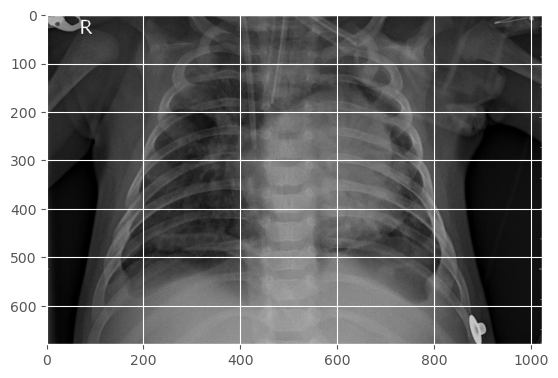

In [116]:
plt.imshow(test_img)
plt.show()

In [118]:
test_img.shape

(680, 1024, 3)

In [120]:
test_img = cv2.resize(test_img,(128,128))

In [122]:
test_img.shape

(128, 128, 3)

In [124]:
test_img = test_img.reshape((1,128,128,3))

In [126]:
test_img.shape

(1, 128, 128, 3)

In [128]:
np.argmax(model_01.predict(test_img),axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


array([0])

In [96]:
1.000000e+00 >1.286693e-11

True